# KNN experiment on iris dataset

## prepping

In [1]:
from sklearn import datasets
import pandas as pd

from typing import List

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from plotnine import *
import random

In [2]:
iris_data = datasets.load_iris()
iris = pd.DataFrame(iris_data["data"])
iris.columns = iris_data["feature_names"]
iris_target = pd.Series(iris_data["target"])

In [3]:
n_obs = iris.shape[0]
print("Total n obs", n_obs)
n_obs_fitting = round(n_obs * 0.8)
print("n obs fitting", n_obs_fitting)
n_obs_validation = round(n_obs_fitting * 0.2)
print("n obs validation", n_obs_validation)
print("n obs train", n_obs_fitting - n_obs_validation)

Total n obs 150
n obs fitting 120
n obs validation 24
n obs train 96


In [ ]:
# shuffling data to generate the datasets
indices = iris.index.tolist()
random.Random(5473).shuffle(indices) # fixing the random seed
fitting_indices = indices[:n_obs_fitting]
validation_indices = fitting_indices[-n_obs_validation:]
train_indices: List[int] = [x for x in fitting_indices if x not in validation_indices]
test_indices = [x for x in iris.index if x not in fitting_indices]

In [ ]:
assert len(train_indices) + len(validation_indices) + len(test_indices) == n_obs # making sure number of obs are correct

## (manual) grid search

In [ ]:
# k grid values 
k_grid = [x for x in range(1, 40)]
# distance metric values
distances_grid = ["minkowski", "cosine"]

# create all combinations of hyperparameters
hyperparameters_combos = []
for k in k_grid:
    for d in distances_grid:
        hyperparameters_combos.append( (k, d) )
hyperparameters_combos

In [ ]:
hyperparameter_tuning_results = {}

def fit_knn_model(X_train, y_train, k, metric):
    scaler = StandardScaler()
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    X_scaled = scaler.fit_transform(X_train)
    _ = knn.fit(X_scaled, y_train)
    return knn, scaler

for combo in hyperparameters_combos:
    X_train = iris[iris.index.isin(train_indices)]
    y_train = iris_target[iris_target.index.isin(train_indices)]
    knn, scaler = fit_knn_model(X_train, y_train, combo[0], combo[1])

    X_validation = iris[iris.index.isin(validation_indices)]
    X_validation_scaled = scaler.transform(X_validation)
    y_validation = iris_target[iris.index.isin(validation_indices)]
    y_hat_validation = knn.predict(X_validation_scaled)

    score = f1_score(y_validation, y_hat_validation, average="macro")
    hyperparameter_tuning_results[combo] = {
        "score": score
    }

In [ ]:
hyperparameter_tuning_results

best_combo = None
best_score = 0
for combo in hyperparameter_tuning_results:
    score = hyperparameter_tuning_results[combo]['score']
    if score >= best_score:
        best_score = score
        best_combo = combo
best_score
best_combo

In [ ]:
scores = []
for combo in hyperparameter_tuning_results:
    scores.append( (combo[0], combo[1], hyperparameter_tuning_results[combo]["score"]) )
scores_df = pd.DataFrame(scores, columns=["k", "metric", "score"])

In [ ]:
(
    ggplot(scores_df, aes(x="k", y="score")) +
    geom_point() +
    facet_wrap("metric") +
    ggtitle("F1 score against k value")
)

## Final model

In [ ]:
X_fitting = iris[iris.index.isin(fitting_indices)]
y_fitting = iris_target[iris_target.index.isin(fitting_indices)]

final_knn, scaler = fit_knn_model(X_fitting, y_fitting, best_combo[0], best_combo[1]) #type: ignore

X_test = iris[iris.index.isin(test_indices)]
X_test_scaled = scaler.transform(X_test)
y_hat_test = final_knn.predict(X_test_scaled)
final_score = f1_score(iris_target[iris_target.index.isin(test_indices)], y_hat_test, average="macro")
final_score

## Experiment: repeated sampling validation

In [20]:
def do_grid_search():
    # shuffling data to generate the datasets
    indices = iris.index.tolist()
    random.shuffle(indices) # fixing the random seed
    fitting_indices = indices[:n_obs_fitting]
    validation_indices = fitting_indices[-n_obs_validation:]
    train_indices: List[int] = [x for x in fitting_indices if x not in validation_indices]

    # k grid values 
    k_grid = [x for x in range(1, 40)]
    # distance metric values
    distances_grid = ["minkowski", "cosine"]

    # create all combinations of hyperparameters
    hyperparameters_combos = []
    for k in k_grid:
        for d in distances_grid:
            hyperparameters_combos.append( (k, d) )

    hyperparameter_tuning_results = {}

    def fit_knn_model(X_train, y_train, k, metric):
        scaler = StandardScaler()
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        X_scaled = scaler.fit_transform(X_train)
        _ = knn.fit(X_scaled, y_train)
        return knn, scaler

    for combo in hyperparameters_combos:
        X_train = iris[iris.index.isin(train_indices)]
        y_train = iris_target[iris_target.index.isin(train_indices)]
        knn, scaler = fit_knn_model(X_train, y_train, combo[0], combo[1])

        X_validation = iris[iris.index.isin(validation_indices)]
        X_validation_scaled = scaler.transform(X_validation)
        y_validation = iris_target[iris.index.isin(validation_indices)]
        y_hat_validation = knn.predict(X_validation_scaled)

        score = f1_score(y_validation, y_hat_validation, average="macro")
        hyperparameter_tuning_results[combo] = {
            "score": score
        }

    best_combo = None
    best_score = 0
    for combo in hyperparameter_tuning_results:
        score = hyperparameter_tuning_results[combo]['score']
        if score >= best_score:
            best_score = score
            best_combo = combo
    return (best_combo[0], best_combo[1], best_score) # type: ignore

counter = 0
best_combos = []
while counter < 500:
    best_combos.append(do_grid_search())
    counter = counter + 1

In [14]:
best_combos_df = pd.DataFrame(best_combos, columns=["k", "metric", "score"])

/home/riccardo/miniconda3/envs/teaching/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


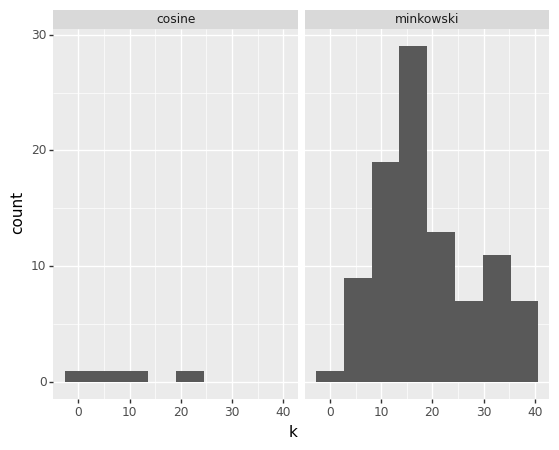

<ggplot: (8726846752952)>

In [17]:
(
    ggplot(best_combos_df, aes(x="k")) +
    geom_histogram() +
    facet_wrap("metric")
)

/home/riccardo/miniconda3/envs/teaching/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


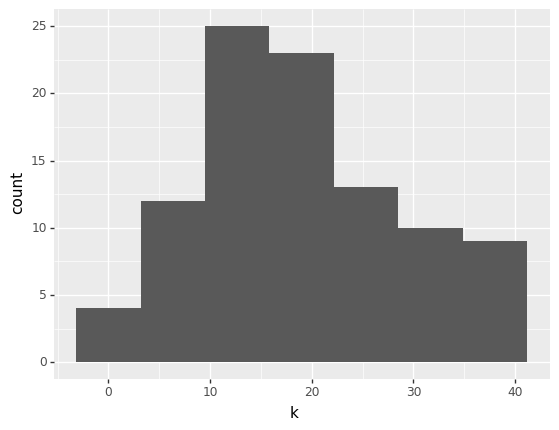

<ggplot: (8726844211600)>

In [21]:
(
    ggplot(best_combos_df.loc[lambda x: x.metric == "minkowski"], aes(x="k")) +
    geom_histogram()
)